# Análise de dados de riscos meteorológicos ao negócio florestal

## Objetivos

O objetivo principal é a obtenção e classificação para os principais riscos climáticos e causas de sinistros meteorológicos para a silvicultura:
- [Geada](#Geada)
- [Vento](#Vento)
- [Chuvas excessivas e inundação](#Chuvas)
- [Déficit hídrico](#seca)

## Metodologia
- Google Earth Engine (GEE) para obtenção e análise de dados de sensoriamento remoto.
- Foi dada ênfase para áreas de silvicultura no Estado de São Paulo, porém as funções podem ser facilmente adaptadas para outros cenários e localidades.
- Fontes de dados:
    - Previsão das principais variáveis meteorológicas - [GFS](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25?hl=en)
        - Resolução espacial: 27830 m
        - As previsões (forecast) do GFS são inicializadas 4 vezes ao dia (00, 06, 12, 18 horas GMT). Portanto, temos 4 forecasts por dia.
        - Nos primeiros 5 dias o intervalo das previsões é de uma hora.
        - Depois em intervalos de 3 horas para os 10 dias seguintes, e 12 horas para os 16 dias restantes. Totalizando 31 dias de forecast.
    - Evapotranspiração - [MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD16A2#description). 
        - Resolução espacial: 500m
        - Resolução temporal: 8 dias
    - Cota do relevo em relação à drenagem - [HAND](https://gee-community-catalog.org/projects/hand/).
        - versão 30_100, i.e., 30 m de resolução espacial e 100 células de drenagem para dar origem a um curso dágua.
    - Modelo digital de elevação - [SRTM](https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4#bands)
        - 90m
    - Uso e ocupação do solo - [MapBiomas coleção 7 (2021)](https://mapbiomas.org/)
        - O recorte para o estado de São Paulo foi feito utilizando o toolkit do GEE disponibilizado pelos desenvolvedores.

## Referências
- [Alvares et al. 2022. Modelagem de áreas propensas à geada para o Eucalipto em São Paulo.](https://www.ipef.br/publicacoes/ctecnica/nr219.pdf)
- [Assad et al. 2021.Impactos de mudanças do clima em plantios de eucalipto no Sul do Brasil](https://www.embrapa.br/busca-de-publicacoes/-/publicacao/1131798/impactos-de-mudancas-do-clima-em-plantios-de-eucalipto-no-sul-do-brasil)
- [Ribeiro et al. 2009. Agrometeorologia dos Cultivos](https://www.embrapa.br/documents/1355291/37056285/Bases+climatol%C3%B3gicas_G.R.CUNHA_Livro_Agrometeorologia+dos+cultivos.pdf/13d616f5-cbd1-7261-b157-351eaa31188d?version=1.0)

## Observações

- Pontos de melhoria: 
    - 1. Foram adotados valores arbitrários, ou baseados em conhecimento tácito, para definir os critérios ao se considerar a temperatura mínima para ocorrência de geada e precipitação acumulada para áreas de inundação. O ideal seria levantar mais informações ou até mesmo realizar experimentos ou ajustar modelos que permitam uma inferência mais assertiva.
    - 2. Para o deficit hídrico foi utilzado, por conveniência, um método bastante simplificado baseado em modelos de sensoriamento remoto com fácil disponibilidade de dados.

In [43]:
import ee
import geemap as gee
import geemap.chart as chart

import datetime as dt

import numpy as np

import matplotlib
# matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd

# import matplotlib.pyplot as plt
# ee.Authenticate()
gee.ee_initialize()

# Setup

In [44]:
begTime = dt.date.today()
today = ee.Date(begTime.strftime("%Y-%m-%d"))

In [45]:
# parâmetros do Earth Engine para visualização das imagens
palette = ['000096','0064ff', '00b4ff', '33db80', '9beb4a', 'ffeb00', 'ffb300', 'ff6400', 'eb1e00', 'af0000'  ]
temperatureVis = {'min': 0, 'max': 40, 'palette': palette}
vis_inc = {'min': 1, 'max': 5, 'palette': ['green', 'lime', 'yellow', 'red', 'maroon']}

# Read

In [46]:
# contorno de São Paulo e do Brasil
df_uf = gpd.read_file('../data/vector/uf_sp.shp')
df_br =  gpd.read_file('../data/vector/br.shp')

In [47]:
bbox = ee.Geometry.Polygon(list(df_uf[df_uf['SIGLA_UF']=='SP'].envelope.geometry.exterior[0].coords))

In [48]:
aoi = ee.Geometry.Polygon(list(df_uf[df_uf['SIGLA_UF']=='SP'].geometry.exterior[0].coords))
br = ee.Geometry.Polygon(list(df_br.geometry.exterior[0].coords))

In [49]:
# ee collections
lulc = ee.Image("projects/ee-lucaspontesm/assets/MAPBIOMAS/mapbiomas-brazil-collection-71-saopaulo-2021")
gfs_collection = ee.ImageCollection('NOAA/GFS0P25')
hand30_1000 = ee.Image("users/gena/GlobalHAND/30m/hand-1000")
hand30_100 = ee.ImageCollection("users/gena/global-hand/hand-100")
dem = ee.Image("CGIAR/SRTM90_V4")
silv = ee.FeatureCollection("projects/ee-lucaspontesm/assets/silvicultura_2021_clean50");

# UDF - User Defined Functions

In [50]:
def gfs_var_prediction(var_name, predict_date, bbox):

    """
    Busca dos dados de previsão meteorológica diária do GFS
    Input:
        - var_name: nome da variável de interesse. (str)
        - predicdt_date: data para qual se deseja obter a previsão. (date)
        - bbox: área de interesse, usada para recortar o raster. (geometry)
    Output:
        - Dado matricial com a previsão meteorológica. (ee.Image)
    """
    
    choose_hours_dict = {1:[0,23],
                        2:[24,47],
                        3:[48,73]}
    
    var_dict = {'Velocidade do vento (m/s)': ['u_component_of_wind_10m_above_ground',
                                              'v_component_of_wind_10m_above_ground'],
                'Temperatura mínima (ºC)':'temperature_2m_above_ground',
                'Umidade relativa do ar (%)':'relative_humidity_2m_above_ground',
                'Precipitação (mm)':'total_precipitation_surface'}

    delta_time = (predict_date - dt.date.today()).days

    # Define os inputs de tempo
    if delta_time > 0:
        today = ee.Date(dt.date.today().strftime("%Y-%m-%d"))
        max_advance = 3
        ti = choose_hours_dict[delta_time][0]
        tf = choose_hours_dict[delta_time][1]
    else:
        delta_time += -1 # força usar a previsao gerada no dia anterior ao que se quer observar
        today = ee.Date((dt.date.today() + dt.timedelta(days=delta_time)).strftime("%Y-%m-%d"))
        max_advance = 1
        ti = choose_hours_dict[1][0]
        tf = choose_hours_dict[1][1]

    # Calcula das predicoes
    # velocidade do vento
    if var_name == 'Velocidade do vento (m/s)':
        var_pred = (gfs_collection
                    .select(['u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground'])
                    .filterDate(today, today.advance(6,'hour')) # get a specific forecast initialization,
                    .filter(ee.Filter.lt('forecast_time',today.advance(max_advance,'day').millis())) # Quantos dias pra frente
                    .filter(ee.Filter.gte('forecast_hours',ti) )
                    .filter(ee.Filter.lte('forecast_hours',tf))
                    .max()) # make a composite of the collection
  
        var_pred = var_pred.clip(bbox)
        # Wind speed
        var_pred = var_pred.pow(2).reduce(ee.Reducer.sum()).sqrt()
    
    # Tmin e UR
    elif var_name in ['Temperatura mínima (ºC)',
                      'Umidade relativa do ar (%)']:
        var_pred = (gfs_collection
                    .select(var_dict[var_name])
                    .filterDate(today, today.advance(6,'hour')) # get a specific forecast initialization,
                    .filter(ee.Filter.lt('forecast_time',today.advance(max_advance,'day').millis())) # Quantos dias pra frente
                    .filter(ee.Filter.gte('forecast_hours',ti) )
                    .filter(ee.Filter.lte('forecast_hours',tf))
                    .min()) # make a composite of the collection
  
        var_pred = var_pred.clip(bbox)

    # Precipitacao diaria total
    elif var_name == 'Precipitação (mm)':
        """Until 2019-11-07 06:00:00, this field represents the precipitation at surface at the forecasted time.
         After that date, this field holds the cumulative precipitation at surface added together from all forecasts 
         starting from hour 0 (only for assets with forecast_hours > 0)"""
        var_pred = (gfs_collection
                    .select(var_dict[var_name])
                    .filterDate(today, today.advance(6,'hour')) # get a specific forecast initialization,
                    .filter(ee.Filter.lt('forecast_time',today.advance(max_advance,'day').millis())) # Quantos dias pra frente
                    .filter(ee.Filter.gte('forecast_hours',ti+1) )
                    .filter(ee.Filter.lte('forecast_hours',tf))
                    .sum()) # make a composite of the collection
  
        var_pred = var_pred.clip(bbox)
        
    return var_pred

# Geada

In [51]:
# Indicência de geada (Alvares et al 2022)
inc = (ee.Image(1)
        .expression('-5.293 +  0.00078 * alt - 0.0857 * (2.303 * hand) - 0.114 * lat - 0.057 * lon',
            {'alt':dem.select("elevation"),
            'lat':hand30_100.mosaic().pixelLonLat().select('latitude'),
            'lon':hand30_100.mosaic().pixelLonLat().select('longitude'),
            'hand':hand30_100.mosaic().select('b1').log()})
         .clip(aoi))

In [52]:
# Classificando os valores da imagem em 5 níveis:
# 1 - muito baixa; 2 - baixa, 3 - média, 4 - alta, 5 - muito alta
inc_classes = (ee.Image(1)
                .where(inc.lte(0.20), 1) 
                .where(inc.gt(0.20).And(inc.lte(0.40)), 2)
                .where(inc.gt(0.40).And(inc.lte(0.60)), 3)
                .where(inc.gt(0.60).And(inc.lte(0.80)), 4)
                .where(inc.gt(0.80), 5)
              )

In [53]:
Map = gee.Map()
vis_inc = {'min': 1, 'max': 5, 'palette': ['green', 'lime', 'yellow', 'red', 'maroon']}
Map.addLayer(inc_classes.clip(aoi),vis_inc,'INC - geada (decimal)')
Map.setCenter(-47.4, -22.8, 7)  
Map

Map(center=[-22.8, -47.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [71]:
# # Histograma
inc_sample = inc_classes.sample(silv, 10000)
options = {
    "title": 'Índice de incidência de geada para áreas de Silvicultura no Estado de São Paulo',
    "xlabel": 'Incidência (inc)',
    "ylabel": 'Pixel count',
    "colors": ['#1d6b99'],
}

# chart.feature_histogram(inc_sample, 'constant',maxBuckets=5, **options)

In [55]:
df = pd.DataFrame(inc_classes.reduceRegion(reducer= ee.Reducer.frequencyHistogram(), 
                    geometry= aoi, 
                    scale= 900).getInfo())
df['perc_inc'] = 100*df['constant']/df['constant'].sum()

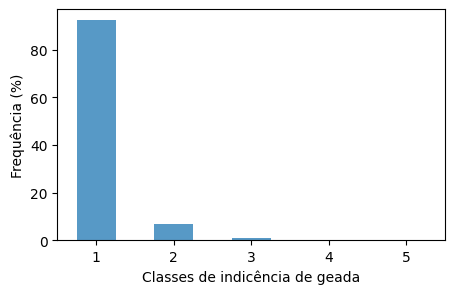

In [56]:
fig, ax = plt.subplots(1, figsize=(5,3))
df['perc_inc'].plot(kind='bar',alpha=0.75, rot=0,ax=ax)
plt.xlabel("Classes de indicência de geada")
plt.ylabel("Frequência (%)")
plt.show()

### Definição de temperaturas de referência
- Uma vez que a escala dos dados do GFS é muito grande em relação às áreas de silvicultura, utilizei o trabalho de Alvares et al (2022) para estimar temperaturas críticas de geada.
- Para isso selecionei áreas de silvicultura do mapeamento do Mapbiomas (2021) (63724,63744,90376,74516,69423) localizadas próximas as áreas apresentadas no estudo e os dados de temperatura mínima para as datas 30 de junho, 20 e 30 de julho de 2021, que chegaram a atingir temperaturas mínimas de -4ºC Alvares et al (2022).
- A temperatura mínima obtida com o GFS para essas datas foi de -1.76ºC, ou seja, cerca de 2ºC acima do medido por Alvares et al (2022)
- Apesar do empirismo desta análise, essas informações foram utilizadas para combinar o índice de incidência de geadas com as temperaturas mínimas do GFS para refinar possíveis alertas de geada para o Estado de São Paulo.

alerta_geada: 
- inc 0-20 & Tmin (GFS) < 0
- inc 20-40 & Tmin (GFS) < 2
- inc 40-60 & Tmin (GFS) < 4
- inc 40-60 & Tmin (GFS) < 6
- inc 80-100 & Tmin (GFS) < 8

In [57]:
# temperaturas mínimas para as áreas de silvicultura próximas ao estudo de Alvares et al (2022)
sample_areas = silv.filter(ee.Filter.inList('fid', [63724,63744,90376,74516,69423,117729]))
var_Tmin = gfs_var_prediction('Temperatura mínima (ºC)', dt.date.fromisoformat('2021-06-30'), sample_areas)
min_30_06 = pd.DataFrame(var_Tmin.reduceRegion(reducer= ee.Reducer.min(), geometry= sample_areas, scale= 900).getInfo(), index=['2023-06-30'])

var_Tmin = gfs_var_prediction('Temperatura mínima (ºC)', dt.date.fromisoformat('2021-07-20'), sample_areas)
min_20_07 = pd.DataFrame(var_Tmin.reduceRegion(reducer= ee.Reducer.min(), geometry= sample_areas, scale= 900).getInfo(), index=['2023-07-20'])

var_Tmin = gfs_var_prediction('Temperatura mínima (ºC)', dt.date.fromisoformat('2021-07-30'), sample_areas)
min_30_07 = pd.DataFrame(var_Tmin.reduceRegion(reducer= ee.Reducer.min(), geometry= sample_areas, scale= 900).getInfo(), index=['2023-07-30'])

pd.concat([min_30_06,min_20_07,min_30_07])

,temperature_2m_above_ground
2023-06-30,2.340204
2023-07-20,0.146661
2023-07-30,-1.758521


In [58]:
Map = gee.Map()

Map.addLayer(inc_classes.clip(sample_areas),vis_inc,'INC')
Map.addLayer(sample_areas,{},'silvicultura')
Map.addLayer(var_Tmin.clip(sample_areas),temperatureVis,'Tmin')

Map.setCenter(-45.7, -23.2, 11)  
Map

Map(center=[-23.2, -45.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

## Risco de geada estimado de acordo com o INC e a Tmin

In [59]:
# Obtem a temperatura mínima estimada para o próximo dia, para a área de interesse (aoi)
# nesse caso as áreas de silvicultura no estado de SP
Tmin_pred = gfs_var_prediction('Temperatura mínima (ºC)', dt.date.fromisoformat('2021-07-30'), aoi)

# Emite o risco de geada pela combinação de nível de incidência e Tmin estimada, de acordo com a regra
"""alerta_geada: 
- inc 0-20 & Tmin (GFS) < -4
- inc 20-40 & Tmin (GFS) < -2
- inc 40-60 & Tmin (GFS) < 0
- inc 40-60 & Tmin (GFS) < 2
- inc 80-100 & Tmin (GFS) < 4
"""

alerta_geada = (ee.Image(1)
                .where(inc_classes.eq(1).And(Tmin_pred.lte(0)), 1) 
                .where(inc_classes.eq(1).And(Tmin_pred.gt(0)), 0) 
                .where(inc_classes.eq(2).And(Tmin_pred.lte(2)), 1)
                .where(inc_classes.eq(2).And(Tmin_pred.gt(2)), 0)
                .where(inc_classes.eq(3).And(Tmin_pred.lte(4)), 1)
                .where(inc_classes.eq(3).And(Tmin_pred.gt(4)), 0)
                .where(inc_classes.eq(4).And(Tmin_pred.lte(6)), 1)
                .where(inc_classes.eq(4).And(Tmin_pred.gt(6)), 0)
                .where(inc_classes.eq(5).And(Tmin_pred.lte(8)), 1)
                .where(inc_classes.eq(5).And(Tmin_pred.gt(8)), 0)
              ).clip(silv)

In [60]:
vis_alerta_geada = {'min': 0, 'max': 1, 'palette': [ 'blue', 'red']}

Map = gee.Map()
Map.addLayer(alerta_geada,vis_alerta_geada,'Alerta de geada')
Map.setCenter(-46, -23, 8)  
Map

Map(center=[-23, -46], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Vento
- Ventos intensos (ventanias ou vendavais)
- A escala de Beaufort classifica o vento de acordo com sua velocidade.
- Danos à cultura de eucalipto ocorrem quando há tombamento ou perda de dominância apical nas árvores. Diversos fatores podem contribuir para que isso ocorra, desde o tipo do solo, genética da planta, densidade e orientação do plantio, etc.
- Foi utilizada a **classe 8 da escala de Beaufort** como limite para a velocidade do vento causar danos à silvicultura. É classificada como ventania, com ventos com velocidade maior ou igual a 62 km/h (17 m/s) e, segundo a escala de Beaufort, pode quebrar galhos de  árvores.

In [61]:
# Previsão da velocidade do vento (m/s) para o próximo dia
VVmax_pred = gfs_var_prediction('Velocidade do vento (m/s)', dt.date.today() + dt.timedelta(days=1), aoi)
Map = gee.Map()

vis_alerta_ventania = {'min': 0, 'max': 17, 'palette': palette}

Map.addLayer(VVmax_pred,vis_alerta_ventania,'Alerta de ventania')
Map.setCenter(-47.4, -22.8, 7)    
Map

Map(center=[-22.8, -47.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

# Chuvas
O eucalipto submetido ao excesso de água, decorrente da alta pluviosidade, pode apresentar
anomalias como a necrose foliar, a presença da seca de ponteiros nos galhos e na haste principal,
brotações adventícias ao longo do fuste e dos galhos, lançamento de folhas com limbo afilado,
deformado e com sintomas de deficiência nutricional, em árvores adultas, além de obstrução com
tiloses em vasos do xilema da haste, do lenho e das raízes.

- Semelhante ao que foi feito para o alerta de geada podemos usar uma combinação do HAND (High Above the Nearest Drainage) com as predições de precipitação diária (mm).
- O desafio é escolher valores de precipitação e HAND que permitam um alerta realista de inundação.
- Com base em análises visuais de imagens de satélite e conhecimento tácito, foram definidos alertas de inundação quando o total acumulado de precipitação para 3 dias superar 100 mm e o valor do HAND for menor ou igual à 10.

In [62]:
today = ee.Date('2023-01-22')
# Precipitacao total 3 dias (próximos 3 dias)
P_3d_pred =  (gfs_collection
            .select('total_precipitation_surface')
            .filterDate(today, today.advance(6,'hour')) # get a specific forecast initialization,
            .filter(ee.Filter.lt('forecast_time',today.advance(3,'day').millis())) # Quantos dias pra frente
            .filter(ee.Filter.gte('forecast_hours',1) )
            .filter(ee.Filter.lte('forecast_hours',72))
            .sum()) # make a composite of the collection
  
P_3d_pred = P_3d_pred.clip(aoi)

In [63]:
risco_inundacao = (ee.Image(1)
                .where(P_3d_pred.gte(100).And(hand30_100.mosaic().select('b1').lte(10)), 1)
                .where(P_3d_pred.gte(100).And(hand30_100.mosaic().select('b1').gt(10)), 0)
                .where(P_3d_pred.lt(100), 0)
                ).clip(aoi)

In [70]:
inundacao_Vis = {'min': 0, 'max': 1, 'palette': ['blue', 'red']}
Map = gee.Map()
Map.addLayer(risco_inundacao, inundacao_Vis, 'Risco de inundação')
Map.setCenter(-47.4, -22.8, 7)      
Map

Map(center=[-22.8, -47.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [69]:
# Visualização da Cota ou hand (height above nearest drainage)
paletteHand = ['023858', '006837', '1a9850', '66bd63', 'a6d96a', 'd9ef8b', 'ffffbf', 'fee08b', 'fdae61', 'f46d43', 'd73027'];
hand_vis = {'min': 1, 'max': 150, 'palette': paletteHand}
Map = gee.Map()
Map.addLayer(hand30_100.mosaic().clip(aoi), hand_vis, 'Cota')
Map.setCenter(-47.4, -22.8, 7)    
Map

Map(center=[-22.8, -47.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

# Seca
A deficiência hídrica se apresenta como o principal fator de risco para a produção do eucalipto no Brasil (Assad et al. 2021).

O déficit hídrico DEF é definido como:
 DEF = ETP - ETR
 
 Em que,
 - ETP = evapotranspiração potencial
 - ETR = evapotranspiração real
 
 Ou seja, o déficit significa quanto a planta deixou de evapotranspirar devido à falta de água no solo. 

A análise do déficit hídrico é feita considerando a evapotranspiração de referência para a cultura e o volume de água armazenado no solo na camada correspondente à zona radicular, mais especificamente a profundidade radicular efetiva. Mesmo com uma profundidade que pode passar de 15m as raízes do eucalito responsáveis pela absorção de água e nutrientes se concentra nos primeiros 20-30 cm de solo.

Uma das formas de se contabilizar o balanço de água no solo é por meio do método proposto por Thornthwaite e Mather (1955), denominado de Balanço Hídrico Climatológico, no qual a partir dos dados de P, de ETP e da CAD, chega-se aos valores de disponibilidade de água no solo (Armazenamento = ARM), de alteração do armazenamento de água do solo (ALT = deltaARM), de evapotranspiração real (ETR), de deficiência hídrica (DEF) e de excedente hídrico (EXC = DP).

Além disso, outros fatores como tipo de solo, relevo e genética desempenham um papel importante no impacto do déficit hídrico na produção. Portanto, a estimativa do déficit hídrico pelo método tradicional de balanço hídrico, como o método de Thorntwaite e Matter, foge do escopo desse trabalho.

Como alternativas poderíamos utilizar dados do catálogo do Google Earth Engine que trazem índices de seca. Como as coleções:
- [GRIDMET](https://developers.google.com/earth-engine/datasets/catalog/GRIDMET_DROUGHT). Apenas EUA.
- [KBDI](https://developers.google.com/earth-engine/datasets/catalog/UTOKYO_WTLAB_KBDI_v1). Apenas para a Ásia

- [TerraClimate](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE). Descontinuado em 2022
- [SPEIbase](https://developers.google.com/earth-engine/datasets/catalog/CSIC_SPEI_2_8). Descontinuado em 2021

Solução:
- [MOD16A2.061](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD16A2). Com as estimativa da evapostranspiração real e potencial.


In [66]:
modis = ee.ImageCollection('MODIS/061/MOD16A2').filter(ee.Filter.date('2023-06-01', '2023-06-30')).first().clip(br)
deficit = ee.Image(1).expression('ETP - ETR', {'ETP':modis.select('PET'),'ETR':modis.select('ET')}).rename('deficit')

In [67]:
deficit.reduceRegion(reducer= ee.Reducer.minMax(), geometry= aoi, scale= 900).getInfo()

{'deficit_max': 452, 'deficit_min': -114}

In [68]:
Map = gee.Map()

evapotranspirationVis = {'min': -100, 'max': 500,
                          'palette':['000096','0064ff', '00b4ff', '33db80', '9beb4a',
                                     'ffeb00', 'ffb300', 'ff6400', 'eb1e00', 'af0000'],
}
Map.setCenter(-40, -12, 4)
Map.addLayer(deficit.clip(br), evapotranspirationVis, 'Déficit hídrico')
Map

Map(center=[-12, -40], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…